In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
kb = 1.380649 * 10**(-23)

In [61]:
def free_energy_diff(s, q, beta):
    """
    Computes beta * (F(s)/N - F(0)/N) from equation (2.45).
    
    Parameters:
        s (float): order parameter
        q (int or float): number of states (Potts model parameter)
        beta (float): inverse temperature (1/kT)
        
    Returns:
        float: free energy difference per site times beta
    """
    term1 = ((1 + (q - 1) * s) / q) * np.log(1 + (q - 1) * s)
    term2 = (q - 1) * ((1 - s) / q) * np.log(1 - s)
    term3 = - q * np.log(q)
    term4 = -0.5 * beta * ((q - 1) / q) * (s**2)
    
    return term1 + term2 + term3 + term4

def solve_s(q, beta, guess=0.5):
    """
    Solve beta * s = ln((1 + (q-1)*s) / (1 - s)) for s.
    
    Parameters:
        q (int): Potts model states
        beta (float): inverse temperature (1/kT)
        guess (float): initial guess for root finder (between 0 and 1)
    
    Returns:
        float: solution for s (in (0,1))
    """
    def equation(s):
        # Avoid singularities
        if s <= 0 or s >= 1:
            return 1e6
        return beta * s - np.log((1 + (q-1)*s) / (1 - s))
    
    root, = fsolve(equation, guess)
    
    # Clip to [0,1] range
    if 0 < root < 1:
        return root
    else:
        return None

In [63]:
S = np.linspace(0,1,1000)
q_values = np.array([2,3,10,100])
beta_values = np.linspace(0,10,11)
k = free_energy_diff(0.0001, 10, 4)
print(f"{k}")

-23.025850902952456


In [41]:
def Plot(s,q,beta):
    j = len(beta)
    for i in range(round(j)):
        F = free_energy_diff(s,q,beta[i])
        plt.plot(s,F, label=f"b = {beta[i]}")
    plt.title(f"F at q ={q} ")
    plt.show()

C:\Users\lucq0\AppData\Local\Temp\ipykernel_9452\257515469.py:14: RuntimeWarning: divide by zero encountered in log
  term2 = (q - 1) * ((1 - s) / q) * np.log(1 - s)
C:\Users\lucq0\AppData\Local\Temp\ipykernel_9452\257515469.py:14: RuntimeWarning: invalid value encountered in multiply
  term2 = (q - 1) * ((1 - s) / q) * np.log(1 - s)


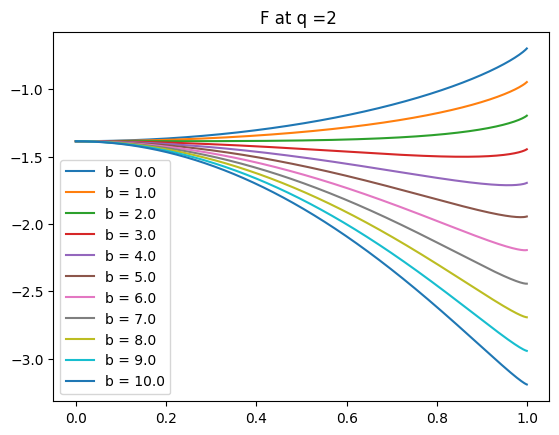

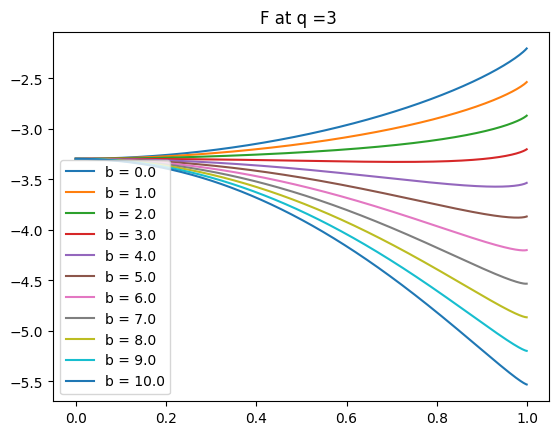

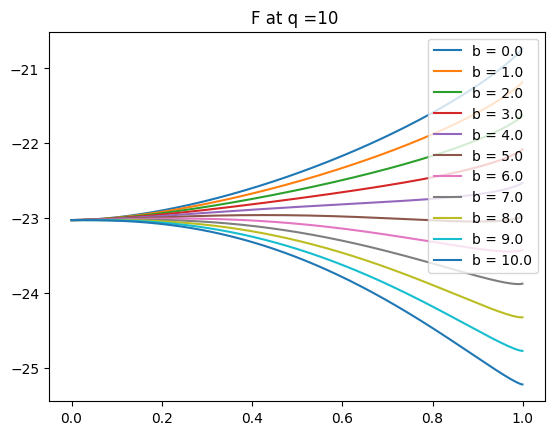

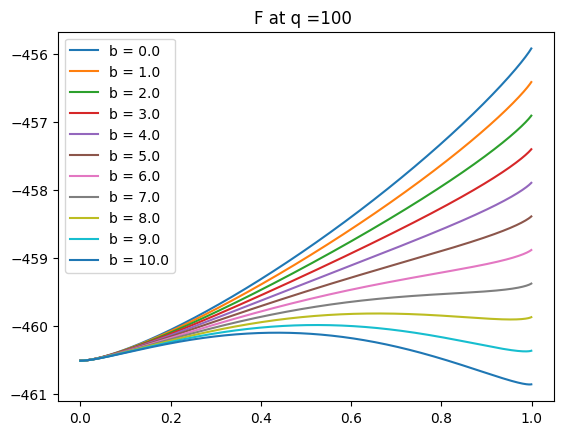

In [28]:

for i in range(4):
    Plot(S,q_values[i],beta_values)

C:\Users\lucq0\AppData\Local\Temp\ipykernel_9452\994793120.py:14: RuntimeWarning: divide by zero encountered in log
  term2 = (q - 1) * ((1 - s) / q) * np.log(1 - s)
C:\Users\lucq0\AppData\Local\Temp\ipykernel_9452\994793120.py:14: RuntimeWarning: invalid value encountered in multiply
  term2 = (q - 1) * ((1 - s) / q) * np.log(1 - s)


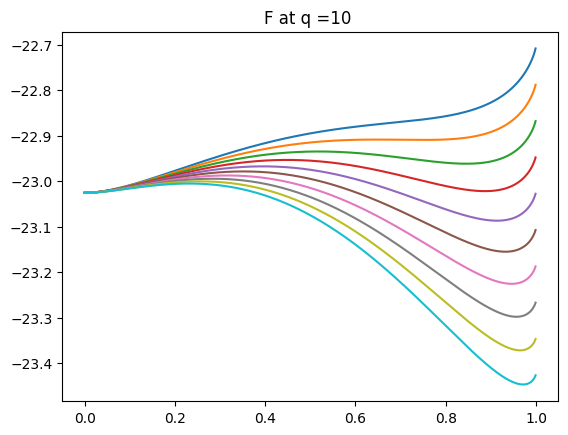

In [60]:
beta1 = np.linspace(4.4,6,10)
S = np.linspace(0,1,1000)
Plot(S,10,beta1)

In [58]:
beta1 = np.linspace(4,10,100)
S = np.zeros(100)
for i,b in enumerate(beta1):
    S[i] = solve_s(10, b, guess=0.5)

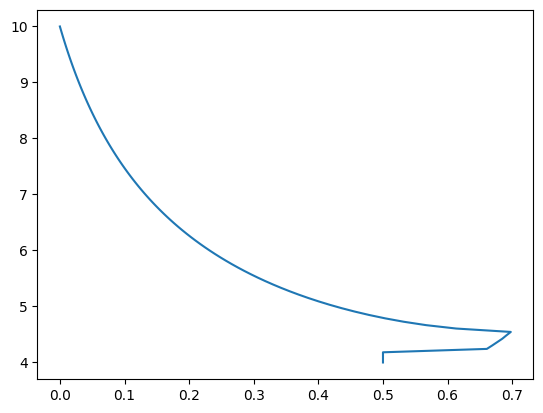

In [59]:
plt.plot(S,beta1)

Exact Tc for q=10: 0.701232
0
100
200
300
400
500
600
700
800
900
Avg energy/site = -0.6355  ± 0.0482
Avg order param  = 0.0532  ± 0.0204


C:\Users\lucq0\AppData\Local\Temp\ipykernel_19328\486317167.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', q)  # 10 distinct colors


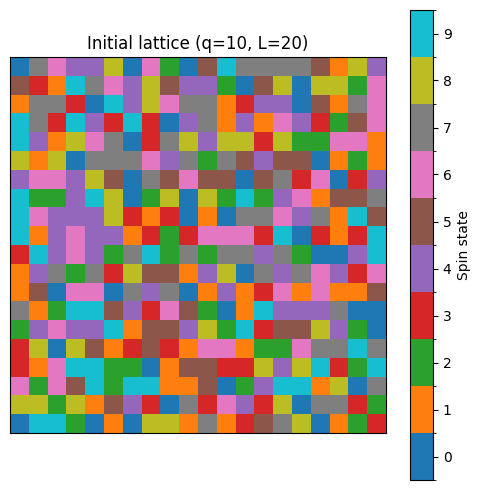

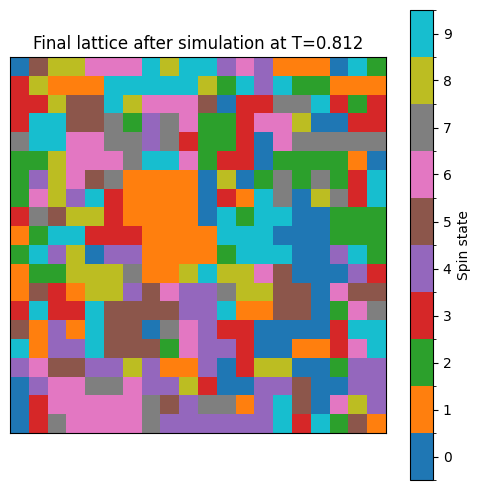

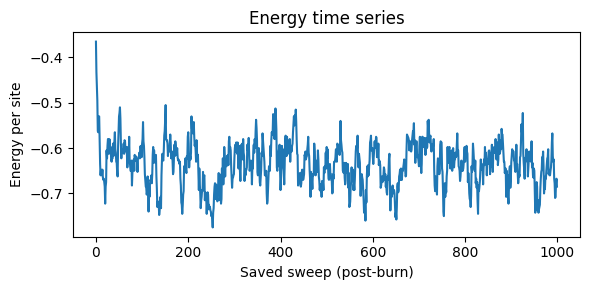

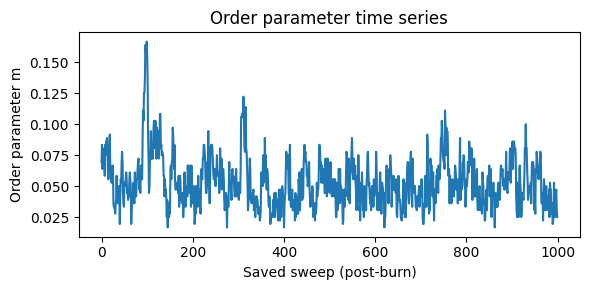

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# ---------- Model helpers ----------
def Tc_exact(q=10):
    """Exact critical temperature for 2D Potts on square lattice (J=kB=1)."""
    return 1.0 / np.log(1.0 + np.sqrt(q))

def majority_order_parameter(spins, q):
    """m in [0,1]; 1 if fully ordered (one color), ~0 if all colors equally present."""
    L = spins.shape[0]
    counts = np.bincount(spins.ravel(), minlength=q)
    pmax = counts.max() / (L * L)
    return (q * pmax - 1) / (q - 1)

# ---------- Metropolis simulation ----------
def metropolis_potts(T, L=48, q=10, sweeps=6000, burn=2000, seed=0):
    """
    Returns:
      e_series, m_series, spins_init, spins_final
    """
    rng = np.random.default_rng(seed)
    spins = rng.integers(0, q, size=(L, L))
    spins_init = spins.copy()
    beta = 1.0 / T

    # periodic neighbor index helpers
    up    = np.r_[ [L-1], np.arange(L-1) ]
    down  = np.r_[ np.arange(1, L), [0] ]
    left  = np.r_[ [L-1], np.arange(L-1) ]
    right = np.r_[ np.arange(1, L), [0] ]

    def local_same(i, j, val):
        # return integer count of same-colored nearest neighbors
        return (int(spins[up[i], j]    == val) +
                int(spins[down[i], j]  == val) +
                int(spins[i, left[j]]  == val) +
                int(spins[i, right[j]] == val))

    e_series, m_series = [], []

    for sweep in range(sweeps):
        for _ in range(L * L):
            i = rng.integers(0, L)
            j = rng.integers(0, L)

            s_old = spins[i, j]
            # propose a different color uniformly among remaining q-1 colors
            s_new = (s_old + 1 + rng.integers(0, q - 1)) % q

            n_old = local_same(i, j, s_old)
            n_new = local_same(i, j, s_new)
            dE = -(n_new - n_old)  # E = -sum delta; changing matches by +1 lowers E by 1

            if dE <= 0 or rng.random() < np.exp(-beta * dE):
                spins[i, j] = s_new
        if sweep%100 == 0:
            print(sweep)

        if sweep >= sweep:#burn:
            # energy per site (count each bond once: +x and +y)
            same_x = (spins == spins[:, right])
            same_y = (spins == spins[down, :])
            e = - (same_x.sum() + same_y.sum()) / (L * L)
            m = majority_order_parameter(spins, q)
            e_series.append(e)
            m_series.append(m)

    return np.array(e_series), np.array(m_series), spins_init, spins.copy()

# ---------- Plotting ----------
def plot_lattice(spins, q=10, title=""):
    """
    Discrete 10-color heatmap for spin states 0..q-1.
    """
    cmap = plt.cm.get_cmap('tab10', q)  # 10 distinct colors
    norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, q + 0.5, 1), ncolors=q)
    plt.figure(figsize=(5, 5))
    im = plt.imshow(spins, cmap=cmap, norm=norm, interpolation='nearest')
    cbar = plt.colorbar(im, ticks=np.arange(0, q, 1))
    cbar.set_label('Spin state')
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show()

# ---------- Example run ----------
if __name__ == "__main__":
    q = 10
    L = 20
    T = 0.81232  # near Tc; try 0.68 (ordered), 0.74 (disordered), 0.70–0.72 (mixed/flip)
    sweeps = 1000
    burn = 400
    seed = 42

    print(f"Exact Tc for q={q}: {Tc_exact(q):.6f}")

    e, m, spins0, spinsF = metropolis_potts(T, L=L, q=q, sweeps=sweeps, burn=burn, seed=seed)

    print(f"Avg energy/site = {e.mean():.4f}  ± {e.std():.4f}")
    print(f"Avg order param  = {m.mean():.4f}  ± {m.std():.4f}")

    # Heatmaps: before (random) and after (post-simulation)
    plot_lattice(spins0, q=q, title=f"Initial lattice (q={q}, L={L})")
    plot_lattice(spinsF, q=q, title=f"Final lattice after simulation at T={T:.3f}")

    # Optional: quick time series plots
    plt.figure(figsize=(6,3))
    plt.plot(e)
    plt.xlabel("Saved sweep (post-burn)")
    plt.ylabel("Energy per site")
    plt.title("Energy time series")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(m)
    plt.xlabel("Saved sweep (post-burn)")
    plt.ylabel("Order parameter m")
    plt.title("Order parameter time series")
    plt.tight_layout()
    plt.show()


'\nfor i in range(L):\n    for j in range(L):\n        if m[i,j] == True:\n            if mc[i,j-1] != 0:\n                mc[i,j] = mc[i,j-1]\n            elif mc[i-1,j] != 0:\n                mc[i,j] = mc[i-1,j]\n            else:\n                mc[i,j] = count\n            \n        else:\n            count += 1\n'

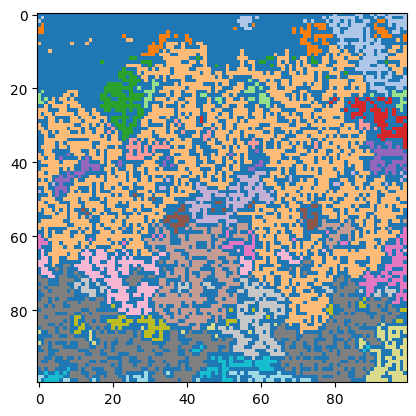

In [44]:
L = 100
A = np.random.uniform(size = (L,L))

p = np.linspace(0.5,0.7,10)
m  = A < p[4]
mc = np.zeros((L,L))
k,n = label(m, structure=structure)
plt.imshow(k*100,cmap = 'tab20')
count = 1
'''
for i in range(L):
    for j in range(L):
        if m[i,j] == True:
            if mc[i,j-1] != 0:
                mc[i,j] = mc[i,j-1]
            elif mc[i-1,j] != 0:
                mc[i,j] = mc[i-1,j]
            else:
                mc[i,j] = count
            
        else:
            count += 1
'''


In [43]:
print(k)

[[ 0  1  1  1  1  0  2  0  0  3]
 [ 4  0  1  1  1  1  0  0  0  3]
 [ 0  1  1  0  0  1  1  0  0  0]
 [ 5  0  0  6  0  0  1  0  0  7]
 [ 5  0  8  0  9  0  1  1  0  0]
 [ 0  8  8  0  9  9  0  1  0  0]
 [ 8  8  0  9  0  9  9  0 10  0]
 [ 8  0  9  9  9  9  9  0  0 11]
 [ 8  8  0  9  0  9  9  0 11 11]
 [ 8  8  0  9  9  9  0 12  0 11]]


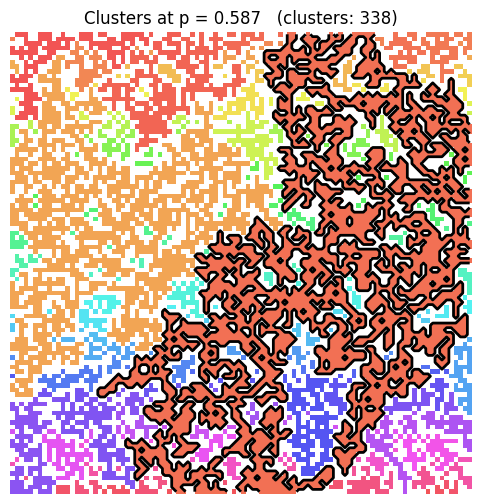

Estimated p_c (this sample & size): 0.5868686868686869


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from matplotlib import colors as mcolors

L = 100
A = np.random.rand(L, L)                 # fixed disorder so occupancy grows monotonically with p
ps = np.linspace(0.50, 0.70, 100)         # scan p's

# 4-neighbour connectivity (use a 3x3 cross)
structure = np.array([[0,1,0],
                      [1,1,1],
                      [0,1,0]], dtype=bool)

def colorize_labels(labels):
    n = labels.max()
    if n == 0:
        return np.zeros((*labels.shape, 3))   # nothing there
    # distinct colors via HSV wheel, plus color for background (label 0)
    hues = np.linspace(0, 1, n, endpoint=False)
    rgb = mcolors.hsv_to_rgb(np.c_[hues, np.full(n, 0.65), np.full(n, 0.95)])
    cmap = mcolors.ListedColormap(np.vstack(([1,1,1], rgb)))  # white for background
    return cmap

def percolating_ids(labels):
    # ids that touch both left-right or top-bottom
    left   = set(np.unique(labels[:, 0]))  - {0}
    right  = set(np.unique(labels[:, -1])) - {0}
    top    = set(np.unique(labels[0, :]))  - {0}
    bottom = set(np.unique(labels[-1, :])) - {0}
    hspan = sorted(left.intersection(right))
    vspan = sorted(top.intersection(bottom))
    return sorted(set(hspan + vspan))

p_c_est = None
for p in ps:
    m = A < p
    labels, n = label(m, structure=structure)
    if p_c_est is None and len(percolating_ids(labels)) > 0:
        p_c_est = float(p)

# Visualize one p (e.g., the first percolating p)
p_show = p_c_est if p_c_est is not None else ps[len(ps)//2]
m_show = A < p_show
labels_show, n_show = label(m_show, structure=structure)
cmap = colorize_labels(labels_show)

plt.figure(figsize=(6,6))
im = plt.imshow(labels_show, cmap=cmap, interpolation='nearest')
plt.title(f"Clusters at p = {p_show:.3f}   (clusters: {n_show})")
plt.axis('off')

# Outline any percolating cluster(s)
perc = percolating_ids(labels_show)
if perc:
    mask = np.isin(labels_show, perc)
    plt.contour(mask, levels=[0.5], linewidths=2.0, colors='k')

plt.show()

print("Estimated p_c (this sample & size):", p_c_est)
